## Load and transform data

### Load libraries

In [14]:
# Main libraries

import pandas as pd
import numpy as np
import sktime as sktime
import warnings

# Get functions from sktime

from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS

# Models

from sklearn.neighbors import KNeighborsRegressor

# Filter warnings

warnings.filterwarnings("ignore")

### Hyperparameters

In [15]:
# Variable to forecast
    
selected_var = "car"

# Parameters

test_size = 0.20

# Season cycle

season_cycle = 12

### Load data

In [16]:
# Load data

data = pd.read_excel("Output/data_ready.xlsx")
number_rows = data['Date'].count()
print(number_rows)

204


### Parameters

In [17]:
# Time series
    
# Wrangling

df = data[['Date',selected_var]]
df[selected_var] = df[selected_var].astype(np.float64)
dates0 = pd.date_range(min(df['Date']), freq = 'M', periods = number_rows)
dates = pd.PeriodIndex(df['Date'], freq = "M")
ts0 = pd.Series(df[selected_var].values, index = pd.date_range(min(df['Date']), freq = 'M', periods = number_rows))
ts = pd.Series(df[selected_var].values, index = dates)

# Total size
    
number_points = ts.count()
number_split = int(number_points*test_size)
    
# Y train and Y test
    
y_train, y_test = temporal_train_test_split(ts, test_size = number_split)

# As numeric 

y_train = pd.to_numeric(y_train)
y_test = pd.to_numeric(y_test)
    
# Horizon
    
fh = np.arange(len(y_test))+1

fh = pd.to_numeric(fh)

### Train and test

In [18]:
print("Observations in train: ", number_points - number_split)
print("Observations in test: ", number_split)

Observations in train:  164
Observations in test:  40


### Optimization

0.062


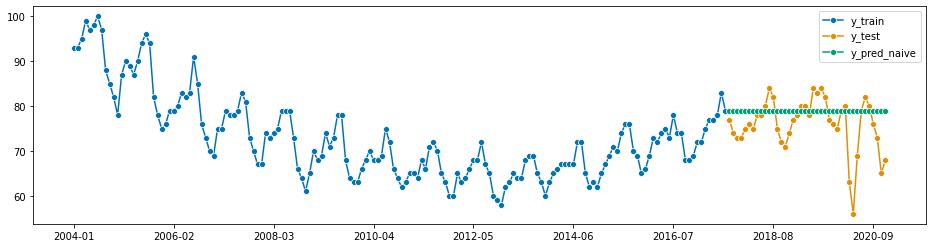

In [19]:
# Naive

forecaster_naive = NaiveForecaster(strategy = "last")
forecaster_naive.fit(y_train)
y_pred_naive = forecaster_naive.predict(fh)
    
# Save results
    
optim_plot_naive = plot_series(y_train, y_test, y_pred_naive, labels = ["y_train", "y_test", "y_pred_naive"])
optim_plot_naive
smape_naive = round(smape_loss(y_pred_naive, y_test),3)
print(smape_naive)

0.061


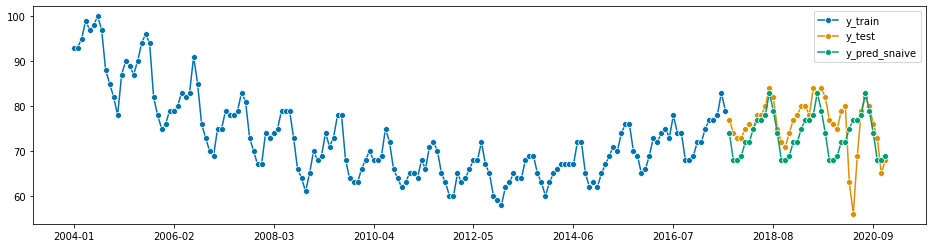

In [20]:
# Snaive

forecaster_snaive = NaiveForecaster(strategy = "last", sp = season_cycle)
forecaster_snaive.fit(y_train)
y_pred_snaive = forecaster_snaive.predict(fh)
    
# Save results
    
optim_plot_snaive = plot_series(y_train, y_test, y_pred_snaive, labels = ["y_train", "y_test", "y_pred_snaive"])
optim_plot_snaive
smape_snaive = round(smape_loss(y_pred_snaive, y_test),3)
print(smape_snaive)

0.051


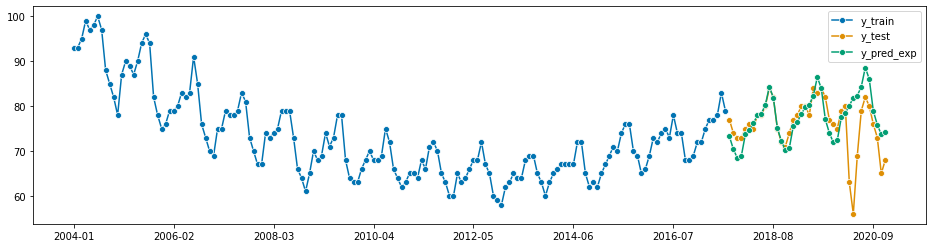

In [21]:
# Exp Smoothing

forecaster_exp = ExponentialSmoothing(trend = "add", seasonal=  "multiplicative", sp=12)
forecaster_exp.fit(y_train)
y_pred_exp = forecaster_exp.predict(fh)
    
# Save results
    
optim_plot_exp = plot_series(y_train, y_test, y_pred_exp, labels = ["y_train", "y_test", "y_pred_exp"])
optim_plot_exp
smape_exp = round(smape_loss(y_pred_exp, y_test),3)
print(smape_exp)

0.051


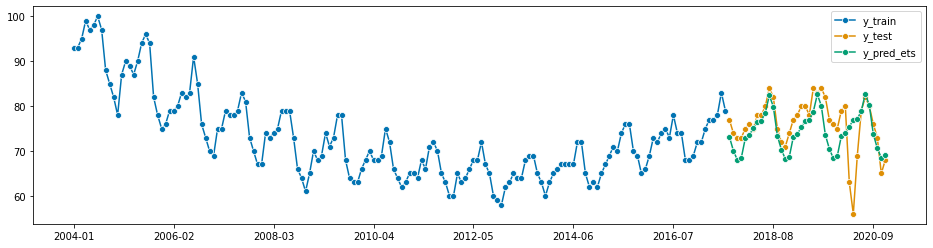

In [22]:
# ETS

forecaster_ets = AutoETS(auto = True, sp = 12, n_jobs = -1)
forecaster_ets.fit(y_train)
y_pred_ets = forecaster_ets.predict(fh)
    
# Save results
    
optim_plot_ets = plot_series(y_train, y_test, y_pred_ets, labels=  ["y_train", "y_test", "y_pred_ets"])
optim_plot_ets
smape_ets = round(smape_loss(y_pred_exp, y_test),3)
print(smape_ets)

In [10]:
# Arima

forecaster_arima = AutoARIMA(sp = 12, suppress_warnings = True)
forecaster_arima.fit(y_train)
y_pred_arima = forecaster_arima.predict(fh)
    
# Save results
    
optim_plot_arima = plot_series(y_train, y_test, y_pred_snaive, labels = ["y_train", "y_test", "y_pred_arima"])
optim_plot_arima
smape_arima = round(smape_loss(y_pred_arima, y_test),3)
print(smape_arima)

In [11]:
# Ensemble

forecaster_ensemble = EnsembleForecaster(
    [
        ("ses", ExponentialSmoothing(seasonal = "multiplicative", sp=12)),
        (
            "holt",
            ExponentialSmoothing(
                trend = "add", damped = False, seasonal = "multiplicative", sp=12
            ),
        ),
        (
            "damped",
            ExponentialSmoothing(
                trend="add", damped = True, seasonal = "multiplicative", sp=12
            ),
        ),
    ]
)

forecaster_ensemble.fit(y_train)
y_pred_ensemble = forecaster_ensemble.predict(fh)
    
# Save results
    
optim_plot_ensemble = plot_series(y_train, y_test, y_pred_snaive, labels = ["y_train", "y_test", "y_pred_ensemble"])
optim_plot_ensemble
smape_ensemble = round(smape_loss(y_pred_ensemble, y_test),3)
print(smape_ensemble)

TypeError: __init__() got an unexpected keyword argument 'damped'

{'window_length': 15}
0.101


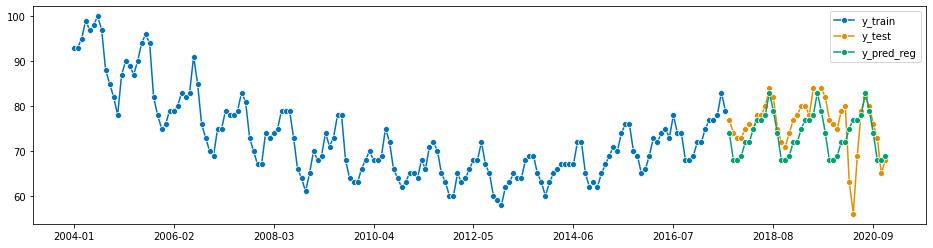

In [12]:
# Reduced regression

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster_reg = ReducedRegressionForecaster(
    regressor = regressor, window_length=15, strategy="recursive"
)
param_grid = {"window_length": [5, 10, 15]}

# Optim

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster_reg, cv = cv, param_grid = param_grid)
gscv.fit(y_train)
y_pred_reg = gscv.predict(fh)

# Best window

print(gscv.best_params_)

# Save results

optim_plot_reg = plot_series(y_train, y_test, y_pred_snaive, labels = ["y_train", "y_test", "y_pred_reg"])
optim_plot_reg
smape_reg = round(smape_loss(y_pred_reg, y_test),3)
print(smape_reg)

In [13]:
# Results object

results = {"Naive":[smape_naive],"Snaive":[smape_snaive],"Exponential":[smape_exp],
           "ETS":[smape_ets],"Arima":[smape_arima],"Ensemble":[smape_ensemble],
           "Regression":[smape_reg]}

optim_models = pd.DataFrame(results, columns = ["Naive","Snaive","Exponential",
                                                "ETS","Arima","Ensemble",
                                                "Regression"], 
                            index = [selected_var])

print(optim_models)

# Write object

optim_models.to_excel("Output/optimization.xlsx",index=True)  

NameError: name 'smape_ensemble' is not defined